In [1]:
import ee
import numpy as np
import pandas as pd
import geopandas as gpd
import os

from earthshot import mon_stats
from earthshot import water_viz as vis
from earthshot import normalize as norm
from statistics import mean

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import xgboost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import shap
shap.initjs()

Loading BokehJS ...

In [3]:
#Initialize Earth Engine
#ee.Authenticate()
ee.Initialize()

In [4]:
#Function to convert FeatureCollection into DataFrame
def fc2df(fc):
    # Convert a FeatureCollection into a pandas DataFrame
    # Features is a list of dict with the output
    features = fc.getInfo()['features']

    dictarr = []

    for f in features:
        # Store all attributes in a dict
        attr = f['properties']
        # and treat geometry separately
        attr['geometry'] = f['geometry']  # GeoJSON Feature!
        # attr['geometrytype'] = f['geometry']['type']
        dictarr.append(attr)

    df = gpd.GeoDataFrame(dictarr)
    # Convert GeoJSON features to shape
    df['geometry'] = map(lambda s: np.shape(s), df.geometry)    
    return df

In [5]:
#Function to convert an image into featurecollection into Dataframe for ML processing
def extract_point_values(img_name, pts):
    image = img_name

    fc_image_red = image.reduceRegions(collection=pts,
                                  reducer=ee.Reducer.mean(),
                                  scale=30)

    # Convert to Pandas Dataframe
    df_image_red = fc2df(fc_image_red)


    return df_image_red

In [6]:
#Import Global MAR Inventory
MAR_swales = ee.FeatureCollection('users/amgadellaboudy/Global_MAR_Inventory')

In [7]:
#Import variables in (Slope, Porosity, Runoff, Soil Types, Annual Precipitation), restrict to global MAR locations
slope_img = ee.Image('users/jamesmcc/merit_slope/merit_terrain_slope').clip(MAR_swales)

smap_usda_clim = ee.ImageCollection('users/jamesmcc/smap_usda_climatology')
avail_porosity = (smap_usda_clim
                  .filter(ee.Filter.eq('band', 'avail_porosity_mm')))
avail_porosity_img = avail_porosity.sum()
avail_porosity_img= avail_porosity_img.clip(MAR_swales)

runoff_clim = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").select('surface_runoff')
runoff_clim_m = mon_stats.bands_avgs(['surface_runoff'], runoff_clim)
runoff_img = ee.ImageCollection(runoff_clim_m['avgs'].get('surface_runoff')).sum().multiply(720)
runoff_img = runoff_img.clip(MAR_swales)

precip_clim = ee.Image("OpenLandMap/CLM/CLM_PRECIPITATION_SM2RAIN_M/v01")
precip_img = precip_clim.reduce('sum')
precip_img = precip_img.clip(MAR_swales)

soil_types = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")

top_soils = soil_types.expression('soil_0 + soil_10 + soil_30',
                             {'soil_0': soil_types.select('b0'),
                             'soil_10': soil_types.select('b10'),
                             'soil_30': soil_types.select('b30')})

bottom_soils = soil_types.expression('soil_60 + soil_100 + soil_200',
                                 {'soil_60': soil_types.select('b60'),
                                  'soil_100': soil_types.select('b100'),
                                  'soil_200': soil_types.select('b200')})

top_soil_img = top_soils.clip(MAR_swales)
bottom_soil_img = bottom_soils.clip(MAR_swales)

water_img = ee.Image('WWF/HydroSHEDS/15ACC').select('b1')
water_img = water_img.clip(MAR_swales)

In [8]:
#Create dataframes out of each variable, concatenate them to create dataframe for ML

df_slope = extract_point_values(slope_img, MAR_swales)
df_slope.rename(columns = {'mean' : 'Slope'}, inplace = True)

porosity = extract_point_values(avail_porosity_img, MAR_swales)
porosity.rename(columns = {'mean' : 'Porosity'}, inplace = True)
porosity = porosity['Porosity']

runoff = extract_point_values(runoff_img, MAR_swales)
runoff.rename(columns = {'mean' : 'Runoff'}, inplace = True)
runoff = runoff['Runoff']

top_soil = extract_point_values(top_soil_img, MAR_swales)
top_soil.rename(columns = {'mean' : 'Top Soils'}, inplace = True)
top_soil = top_soil['Top Soils']

bottom_soil = extract_point_values(bottom_soil_img, MAR_swales)
bottom_soil.rename(columns = {'mean' : 'Bottom Soils'}, inplace = True)
bottom_soil = bottom_soil['Bottom Soils']

precip = extract_point_values(precip_img, MAR_swales)
precip.rename(columns = {'mean' : 'Precip'}, inplace = True)
precip = precip['Precip']

water = extract_point_values(water_img, MAR_swales)
water.rename(columns = {'mean' : 'Water'}, inplace = True)
water = water['Water']

df_all = pd.concat([df_slope, porosity, runoff, top_soil, bottom_soil, precip, water], axis = 1)

df_all.head()

Geometry column does not contain geometry.


,continent,country,fid,final_use,id,influent_s,latitude,link_to_do,longitude,main_mar_t,...,specific_m,year_opera,year_shut_,geometry,Porosity,Runoff,Top Soils,Bottom Soils,Precip,Water
0,Africa,Algeria,1125,Agricultural,1341,River water,36.538316,no data,3.061936,Spreading Methods,...,no data,2002,-9999,<map object at 0x7fa1d16748e0>,NaN,0.441760,21.0,15.0,661,2362.0
1,North America,USA,1028,no data,1098,no data,35.372068,Reverse Drainage,-106.663641,Spreading Methods,...,Reverse Drainage,-9999,-9999,<map object at 0x7fa1d16748e0>,890.502527,0.045776,18.0,18.0,250,2.0
2,North America,USA,1064,Agricultural,1134,River water,45.945574,Reverse Drainage,-118.410467,Spreading Methods,...,Reverse Drainage,2012,-9999,<map object at 0x7fa1d16748e0>,1184.378527,0.246434,21.0,18.0,435,4.0
3,Oceania,Australia,660,Domestic,718,Storm water,-33.918488,Reverse Drainage,151.227858,Spreading Methods,...,Reverse Drainage,2006,-9999,<map object at 0x7fa1d16748e0>,1088.374790,0.136059,24.0,18.0,1025,3.0
4,Oceania,Australia,654,Ecological,712,Reclaimed wastewater,-31.943780,Reverse Drainage,115.780462,Spreading Methods,...,Reverse Drainage,2008,-9999,<map object at 0x7fa1d16748e0>,NaN,0.142747,24.0,18.0,642,3.0


In [9]:
#View new dataframe
df_new = df_all[['latitude','longitude','Slope','Porosity','Runoff','Top Soils','Bottom Soils', 'Precip', 'Water','main_mar_t']]
df_new.head()

,latitude,longitude,Slope,Porosity,Runoff,Top Soils,Bottom Soils,Precip,Water,main_mar_t
0,36.538316,3.061936,1.877370,NaN,0.441760,21.0,15.0,661,2362.0,Spreading Methods
1,35.372068,-106.663641,1.629380,890.502527,0.045776,18.0,18.0,250,2.0,Spreading Methods
2,45.945574,-118.410467,0.723436,1184.378527,0.246434,21.0,18.0,435,4.0,Spreading Methods
3,-33.918488,151.227858,4.182118,1088.374790,0.136059,24.0,18.0,1025,3.0,Spreading Methods
4,-31.943780,115.780462,4.174559,NaN,0.142747,24.0,18.0,642,3.0,Spreading Methods


In [10]:
#Setup Random Forest Classifier model
from sklearn.model_selection import train_test_split
df_random = df_new.dropna()
X = df_random.drop('main_mar_t', axis =1)
y = df_random['main_mar_t']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [13]:
#Test model for accuracy
rfc_pred = rfc.predict(X_test)

In [14]:
#Report precision, recall, f1-score results
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,rfc_pred))

                                   precision    recall  f1-score   support

          In-Channel Modification       0.80      0.75      0.77        32
          Induced Bank Filtration       0.70      0.67      0.68        24
 Rainwater and Run-off Harvesting       0.71      0.56      0.63         9
                Spreading Methods       0.72      0.68      0.70        57
Well, Shaft and Borehole Recharge       0.70      0.80      0.75        56

                         accuracy                           0.72       178
                        macro avg       0.73      0.69      0.71       178
                     weighted avg       0.73      0.72      0.72       178



In [15]:
#Setup data for Tabnet Classifier

train = df_random

n_total = len(train)

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [16]:
#Setup data for Tabnet Classifier

categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)


main_mar_t 5



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
#Setup data for Tabnet Classifier

unused_feat = []
target = 'main_mar_t'

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [18]:
#Initiate TabNet Classifier

clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cpu


In [19]:
#Setup and train Tabnet model

if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [20]:
max_epochs = 500 if not os.getenv("CI", False) else 200

In [21]:
#Fit data into model

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=64, virtual_batch_size= 32
) 

epoch 0  | loss: 2.41185 | train_accuracy: 0.30021 | valid_accuracy: 0.33193 |  0:00:01s
epoch 1  | loss: 2.16802 | train_accuracy: 0.26004 | valid_accuracy: 0.26891 |  0:00:03s
epoch 2  | loss: 1.62633 | train_accuracy: 0.22622 | valid_accuracy: 0.2563  |  0:00:04s
epoch 3  | loss: 1.57632 | train_accuracy: 0.31712 | valid_accuracy: 0.33193 |  0:00:06s
epoch 4  | loss: 1.57585 | train_accuracy: 0.24736 | valid_accuracy: 0.29412 |  0:00:07s
epoch 5  | loss: 1.38091 | train_accuracy: 0.27696 | valid_accuracy: 0.28992 |  0:00:10s
epoch 6  | loss: 1.34383 | train_accuracy: 0.36364 | valid_accuracy: 0.47479 |  0:00:11s
epoch 7  | loss: 1.22828 | train_accuracy: 0.36152 | valid_accuracy: 0.38655 |  0:00:13s
epoch 8  | loss: 1.19464 | train_accuracy: 0.36998 | valid_accuracy: 0.38235 |  0:00:14s
epoch 9  | loss: 1.22491 | train_accuracy: 0.41649 | valid_accuracy: 0.42437 |  0:00:16s
epoch 10 | loss: 1.0891  | train_accuracy: 0.48414 | valid_accuracy: 0.45378 |  0:00:17s
epoch 11 | loss: 1.06

epoch 93 | loss: 0.83841 | train_accuracy: 0.73573 | valid_accuracy: 0.57143 |  0:02:25s
epoch 94 | loss: 0.84405 | train_accuracy: 0.72304 | valid_accuracy: 0.60504 |  0:02:26s
epoch 95 | loss: 0.77728 | train_accuracy: 0.70613 | valid_accuracy: 0.57143 |  0:02:27s
epoch 96 | loss: 0.78101 | train_accuracy: 0.72093 | valid_accuracy: 0.57143 |  0:02:29s
epoch 97 | loss: 0.83372 | train_accuracy: 0.71036 | valid_accuracy: 0.57143 |  0:02:30s
epoch 98 | loss: 0.82883 | train_accuracy: 0.70613 | valid_accuracy: 0.57983 |  0:02:31s
epoch 99 | loss: 0.81248 | train_accuracy: 0.70402 | valid_accuracy: 0.58403 |  0:02:33s
epoch 100| loss: 0.79388 | train_accuracy: 0.70402 | valid_accuracy: 0.57143 |  0:02:34s
epoch 101| loss: 0.78966 | train_accuracy: 0.72304 | valid_accuracy: 0.57563 |  0:02:36s
epoch 102| loss: 0.82364 | train_accuracy: 0.70613 | valid_accuracy: 0.58403 |  0:02:37s
epoch 103| loss: 0.80776 | train_accuracy: 0.72939 | valid_accuracy: 0.59244 |  0:02:39s
epoch 104| loss: 0.75

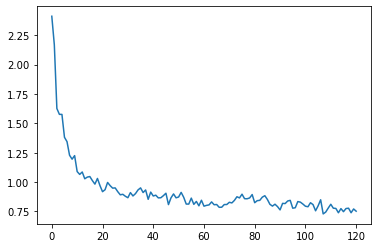

In [22]:
# Plot losses
plt.plot(clf.history['loss'])

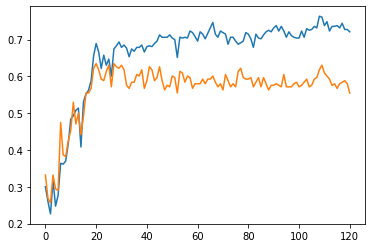

In [23]:
# Plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [24]:
# Use predict method to note accuracy

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR MAR CLASSIFIER : {test_acc}")

FINAL TEST SCORE FOR MAR CLASSIFIER : 0.601123595505618


In [25]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [26]:
#Initiate and fit XGBoost model


clf_xgb = XGBClassifier()

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=200,
            verbose= True)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:00:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.33291
[1]	validation_0-mlogloss:1.17609
[2]	validation_0-mlogloss:1.07607
[3]	validation_0-mlogloss:0.99663
[4]	validation_0-mlogloss:0.93840
[5]	validation_0-mlogloss:0.90196
[6]	validation_0-mlogloss:0.87475
[7]	validation_0-mlogloss:0.86298
[8]	validation_0-mlogloss:0.85477
[9]	validation_0-mlogloss:0.84578
[10]	validation_0-mlogloss:0.84493
[11]	validation_0-mlogloss:0.84333
[12]	validation_0-mlogloss:0.84326
[13]	validation_0-mlogloss:0.84624
[14]	validation_0-mlogloss:0.85196
[15]	validation_0-mlogloss:0.85440
[16]	validation_0-mlogloss:0.85824
[17]	validation_0-mlogloss:0.86011
[18]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
#Print out accuracy for XGBoost model

pred_valid = clf_xgb.predict(X_valid)
valid_acc = accuracy_score(y_pred=pred_valid, y_true=y_valid)
print(f"FINAL TEST SCORE FOR MAR CLASSIFIER : {valid_acc}")

pred_test = clf_xgb.predict(X_test)
test_acc = accuracy_score(y_pred=pred_test, y_true=y_test)
print(f"FINAL TEST SCORE FOR MAR CLASSIFIER : {test_acc}")

FINAL TEST SCORE FOR MAR CLASSIFIER : 0.7016806722689075
FINAL TEST SCORE FOR MAR CLASSIFIER : 0.702247191011236


In [28]:
#Fit data to XGBoost Model

X = df_new.drop('main_mar_t', axis =1)
y = df_new['main_mar_t']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb_class = XGBClassifier()

xgb_class.fit(X_train, y_train)


[16:00:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
#Print out test accuracy for XGBoost
pred_test = xgb_class.predict(X_test)
test_acc = accuracy_score(y_pred=pred_test, y_true=y_test)
print(f"FINAL TEST SCORE FOR MAR CLASSIFIER : {test_acc}")

FINAL TEST SCORE FOR MAR CLASSIFIER : 0.6769911504424779


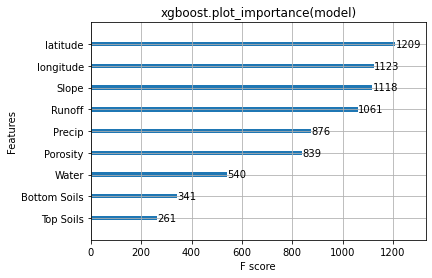

In [30]:
#Show importance of factors in classification
xgboost.plot_importance(xgb_class)
plt.title("xgboost.plot_importance(model)")
plt.show()

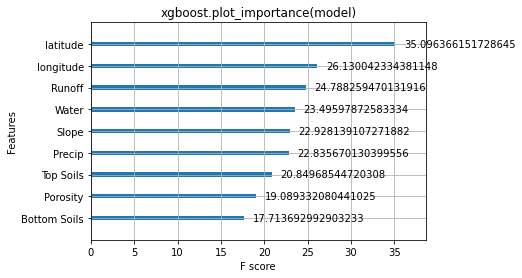

In [31]:
#Shows importance using "cover"

xgboost.plot_importance(xgb_class, importance_type = "cover")
plt.title("xgboost.plot_importance(model)")
plt.show()

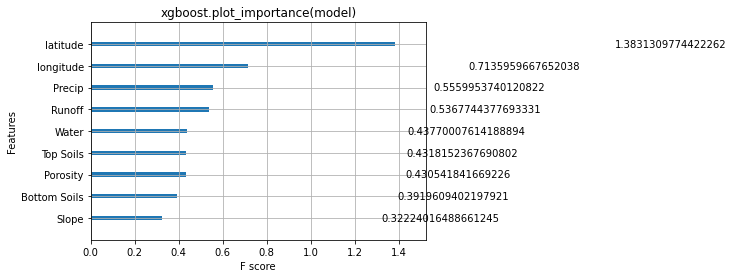

In [32]:
#Shows importance using "gain"

xgboost.plot_importance(xgb_class, importance_type = "gain")
plt.title("xgboost.plot_importance(model)")
plt.show()

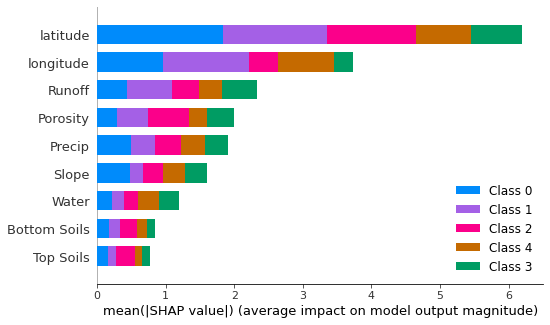

In [34]:
#Plot Shap values for each factor, divided by class
shap.summary_plot(shap_values, X, plot_type="bar")

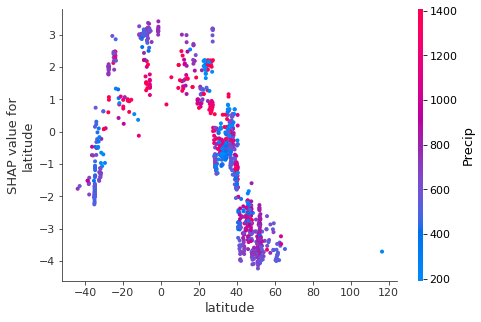

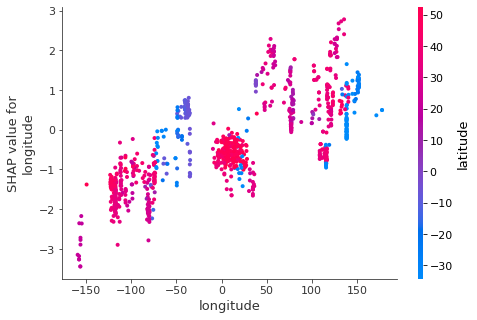

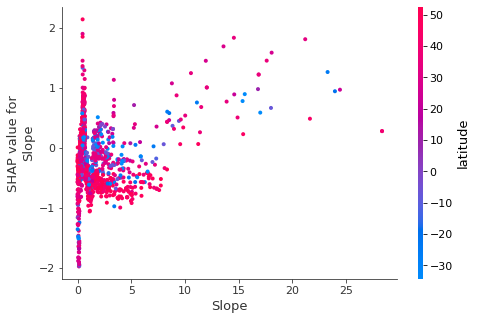

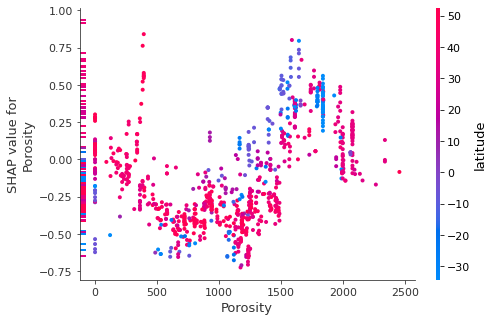

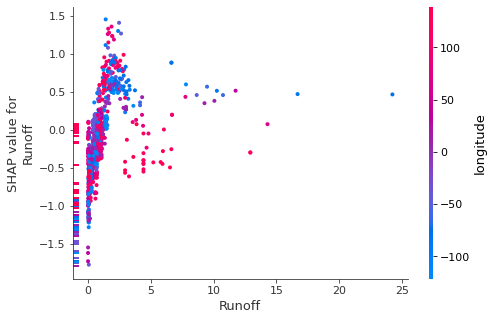

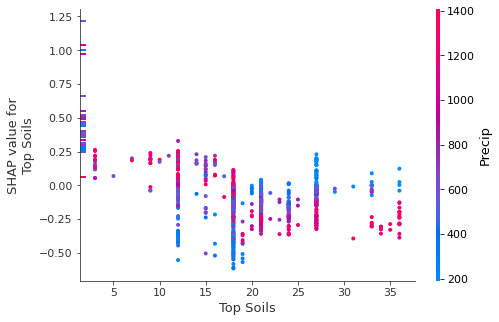

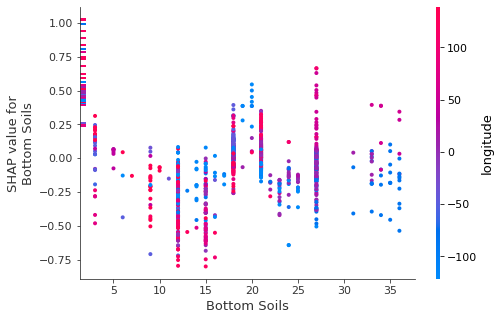

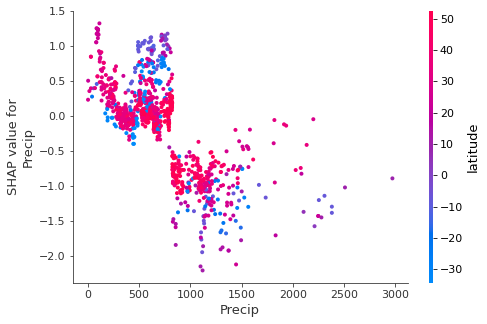

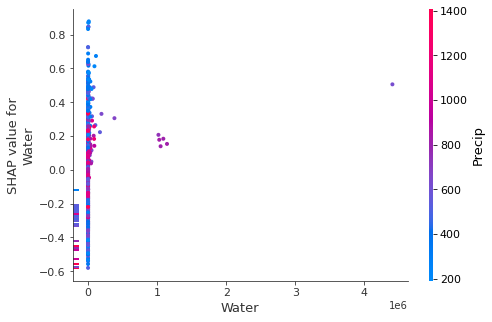

In [35]:
#Compare how shap values vary with different values, and how it correlates with one other factor
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[0], X)